In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as tx
from torchvision.transforms import GaussianBlur
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
image_size = 128
batch_size = 320
def train_augmentation(image, mask, image_size):

    p = 0.5
    
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness=0.5)
    #     image = jitter(image)
    if(random.random() < p):
        angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        translate = (random.uniform(-0.05, 0.05) * image.size[0],
                     random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
        scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
        shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

    
train_dataset = Thyroid_Dataset("train_v3.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("test_v3.csv", transform = test_augmentation, image_size = image_size, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

image, mask, seg_type, from_dataset = next(iter(test_dataloader))
image = image
mask = mask

In [5]:
print("std : ", torch.std(image))
print("unique : ", torch.unique(mask))

std :  tensor(1.0000)
unique :  tensor([0., 1.])


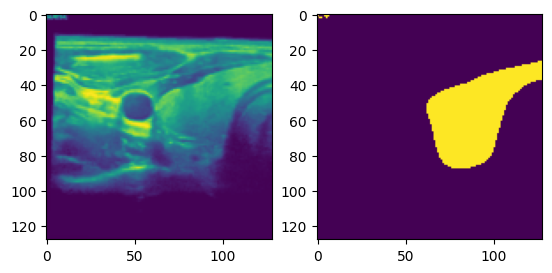

In [6]:
index = 35
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

In [7]:
# model = Eff_Unet(
#         layers=[5, 5, 15, 10],
#         embed_dims=[40, 80, 192, 384],
#         downsamples=[True, True, True, True],
#         vit_num=6,
#         drop_path_rate=0.1,
#         num_classes=1,
#         resolution = image_size).cuda()
# model = HarDMSEG(in_channels = 1)
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = PMFSNet_FFT(in_channels = 1, out_channels = 2, dim = "2d")

In [8]:
# loss_fn_nodule = StructureLoss()
# loss_fn_gland = StructureLoss()

In [9]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
# seg_type

In [11]:
# for epoch in range(1000):
#     outputs = model(image)

#     nodule_output = outputs[:, 0:1, :, :][seg_type==1]
#     nodule_mask = mask[seg_type==1]
    
#     gland_output = outputs[:, 1:2, :, :][seg_type==2]
#     gland_mask = mask[seg_type==2]
#     # outputs = torch.sigmoid(logits)
#     # print(nodule_output.shape, nodule_mask.shape)
#     nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
#     gland_loss = loss_fn_gland(gland_output, gland_mask)
    
#     loss = nodule_loss + gland_loss
    
#     IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
    
#     dice_loss = DiceLoss()
#     # print(dice_loss(nodule_output, nodule_mask))
#     # print(dice_loss(gland_output, gland_mask)) 
#     DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2
    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [12]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(nodule_mask[index][0])
# nodule_output = (nodule_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(nodule_output[index][0].detach().numpy())

In [13]:
# index = 4
# plt.subplot(1,2,1)
# plt.imshow(gland_mask[index][0])
# gland_output = (gland_output > 0.5)
# plt.subplot(1,2,2)
# plt.imshow(gland_output[index][0].detach().numpy())

In [14]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        gland_loss = loss_fn_gland(gland_output, gland_mask)


        
        loss = nodule_loss + gland_loss
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2

        dice_loss = DiceLoss()
        DICE = ((1 - dice_loss(nodule_output, nodule_mask)) + (1 - dice_loss(gland_output, gland_mask))) / 2

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    DDTI_total_loss = 0
    TN3K_total_loss = 0
    TG3K_total_loss = 0
    
    total_IOU = 0
    DDTI_total_IOU = 0
    TN3K_total_IOU = 0
    TG3K_total_IOU = 0
    
    total_DICE = 0
    DDTI_total_DICE = 0
    TN3K_total_DICE = 0
    TG3K_total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type, from_dataset = image.to(device), mask.to(device), seg_type.to(device), from_dataset.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        
        gland_output = outputs[:, 1:2, :, :][seg_type==2]
        gland_mask = mask[seg_type==2]

        DDTI_nodule_output = outputs[:, 0:1, :, :][(from_dataset==1) & (seg_type==1)]
        TN3K_nodule_output = outputs[:, 0:1, :, :][(from_dataset==3) & (seg_type==1)]
        TG3K_gland_output = outputs[:, 1:2, :, :][(from_dataset==2) & (seg_type==2)]

        DDTI_nodule_mask = mask[(from_dataset==1) & (seg_type==1)]
        TN3K_nodule_mask = mask[(from_dataset==3) & (seg_type==1)]
        TG3K_gland_mask = mask[(from_dataset==2) & (seg_type==2)]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask) + loss_fn_gland(gland_output, gland_mask)
        DDTI_nodule_loss = loss_fn_nodule(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_nodule_loss = loss_fn_nodule(TN3K_nodule_output, TN3K_nodule_mask)
        TG3K_gland_loss = loss_fn_gland(TG3K_gland_output, TG3K_gland_mask)
        
        
        IOU = (IOU_score(nodule_output, nodule_mask) + IOU_score(gland_output, gland_mask)) / 2
        DDTI_IOU = IOU_score(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_IOU = IOU_score(TN3K_nodule_output, TN3K_nodule_mask)
        TG3K_IOU = IOU_score(TG3K_gland_output, TG3K_gland_mask)
        

        dice_loss = DiceLoss()
        DICE = (1 - dice_loss(nodule_output, nodule_mask) + 1 - dice_loss(gland_output, gland_mask)) / 2
        DDTI_DICE = 1 - dice_loss(DDTI_nodule_output, DDTI_nodule_mask)
        TN3K_DICE = 1 - dice_loss(TN3K_nodule_output, TN3K_nodule_mask)
        TG3K_DICE = 1 - dice_loss(TG3K_gland_output, TG3K_gland_mask)
    

        total_loss += nodule_loss.item()
        DDTI_total_loss += DDTI_nodule_loss.item()
        TN3K_total_loss += TN3K_nodule_loss.item()
        TG3K_total_loss += TG3K_gland_loss.item()
        
        total_IOU += IOU.item()
        DDTI_total_IOU += DDTI_IOU.item()
        TN3K_total_IOU += TN3K_IOU.item()
        TG3K_total_IOU += TG3K_IOU.item()
        
        total_DICE += DICE.item()
        DDTI_total_DICE += DDTI_DICE.item()
        TN3K_total_DICE += TN3K_DICE.item()
        TG3K_total_DICE += TG3K_DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader), DDTI_total_loss/len(dataloader), DDTI_total_IOU/len(dataloader), DDTI_total_DICE/len(dataloader), TG3K_total_loss/len(dataloader), TG3K_total_IOU/len(dataloader), TG3K_total_DICE/len(dataloader), TN3K_total_loss/len(dataloader), TN3K_total_IOU/len(dataloader), TN3K_total_DICE/len(dataloader), 


    

In [15]:
epochs = 50
lr = 0.01
project = "thyroid"
name="Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [16]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 50, batch size : 320


In [17]:
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)

### If using pretrained model

In [18]:
# pretrained_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 1, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{pretrained_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])

In [19]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [20]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, DDTI_total_loss_val, DDTI_total_IOU_val, DDTI_total_DICE_val, TG3K_total_loss_val, TG3K_total_IOU_val, TG3K_total_DICE_val, TN3K_total_loss_val, TN3K_total_IOU_val, TN3K_total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,

        "DDTI_val_loss": DDTI_total_loss_val,
        "DDTI_val_IOU": DDTI_total_IOU_val,
        "DDTI_val_DICE": DDTI_total_DICE_val,

        "TG3K_val_loss": TG3K_total_loss_val,
        "TG3K_val_IOU": TG3K_total_IOU_val,
        "TG3K_val_DICE": TG3K_total_DICE_val,
        
        "TN3K_val_loss": TN3K_total_loss_val,
        "TN3K_val_IOU": TN3K_total_IOU_val,
        "TN3K_val_DICE": TN3K_total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


train loss : 1.9400899350643157, train IOU : 0.32932826361781736, train DICE : 0.43003672957420347


100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


val loss : 5.227872451146443, val IOU : 0.026116620749235153, val DICE : 0.06556185086568196
epoch : 1


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


train loss : 1.3215259730815887, train IOU : 0.5293308585882187, train DICE : 0.6884714931249618


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.5116409063339233, val IOU : 0.5059526860713959, val DICE : 0.675390621026357
epoch : 2


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 1.1704001486301423, train IOU : 0.5858837813138962, train DICE : 0.7386884719133378


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.3322925368944805, val IOU : 0.5548520584901174, val DICE : 0.7221100827058157
epoch : 3


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 1.1162742733955384, train IOU : 0.6001360893249512, train DICE : 0.7522807776927948


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.3138210773468018, val IOU : 0.5434765716393789, val DICE : 0.7109220921993256
epoch : 4


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 1.0304246246814728, train IOU : 0.631930211186409, train DICE : 0.7753953576087952


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.4915819962819417, val IOU : 0.5078657766183218, val DICE : 0.7022007207075754
epoch : 5


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 1.0898168742656709, train IOU : 0.6114124804735184, train DICE : 0.7631477981805801


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.3300205667813618, val IOU : 0.5464446544647217, val DICE : 0.7206915517648061
epoch : 6


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 1.0096295058727265, train IOU : 0.6354075759649277, train DICE : 0.7808869451284408


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.4452889760335286, val IOU : 0.5325492918491364, val DICE : 0.7148566742738088
epoch : 7


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.9323937267065048, train IOU : 0.663195350766182, train DICE : 0.8038574248552323


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.5093052387237549, val IOU : 0.5145554343859354, val DICE : 0.7031358083089193
epoch : 8


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.8822648048400878, train IOU : 0.6789090454578399, train DICE : 0.8163756608963013


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.2955230275789897, val IOU : 0.570624033610026, val DICE : 0.7572634220123291
epoch : 9


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.8730749368667603, train IOU : 0.6846945255994796, train DICE : 0.817283245921135


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.4182146787643433, val IOU : 0.5568907459576925, val DICE : 0.729106475909551
epoch : 10


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.8310676217079163, train IOU : 0.7008934646844864, train DICE : 0.829920420050621


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 1.3635111848513286, val IOU : 0.5685740212599436, val DICE : 0.7591591874758402
epoch : 11


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


train loss : 0.818880307674408, train IOU : 0.7078360736370086, train DICE : 0.8361462533473969


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 1.783958375453949, val IOU : 0.4678393503030141, val DICE : 0.6762335201104482
epoch : 12


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.8371859222650528, train IOU : 0.6985627025365829, train DICE : 0.8279768168926239


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.197637716929118, val IOU : 0.6064416666825613, val DICE : 0.7706769704818726
epoch : 13


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.7684440672397613, train IOU : 0.7210353910923004, train DICE : 0.8445036739110947


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.2317007382710774, val IOU : 0.6043923298517863, val DICE : 0.7659874260425568
epoch : 14


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.7694697409868241, train IOU : 0.722100681066513, train DICE : 0.848482283949852


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0321560204029083, val IOU : 0.6542612413565317, val DICE : 0.8106288909912109
epoch : 15


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.7311410635709763, train IOU : 0.7371859639883042, train DICE : 0.8545774400234223


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 1.1096159120400746, val IOU : 0.6412366131941477, val DICE : 0.8023879528045654
epoch : 16


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.7051277458667755, train IOU : 0.7454454779624939, train DICE : 0.8610016822814941


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.0516621073087056, val IOU : 0.6557400822639465, val DICE : 0.8140234152475992
epoch : 17


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.6690187484025956, train IOU : 0.7590454965829849, train DICE : 0.8695929199457169


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.1005684932072957, val IOU : 0.646071215470632, val DICE : 0.8083531260490417
epoch : 18


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.6589373648166656, train IOU : 0.7607640713453293, train DICE : 0.8704925537109375


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.1178657015164692, val IOU : 0.6461213429768881, val DICE : 0.7994051973025004
epoch : 19


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.6650067061185837, train IOU : 0.765864172577858, train DICE : 0.873983445763588


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.23712158203125, val IOU : 0.6095616618792216, val DICE : 0.782971719900767
epoch : 20


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


train loss : 0.6481822967529297, train IOU : 0.7670130044221878, train DICE : 0.8735506355762481


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.1011300384998322, val IOU : 0.6556390921274821, val DICE : 0.8021425803502401
epoch : 21


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.6316129475831985, train IOU : 0.7773195981979371, train DICE : 0.8819694221019745


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0627368291219075, val IOU : 0.6621654232343038, val DICE : 0.8147214849789938
epoch : 22


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.6188091397285461, train IOU : 0.7760305732488633, train DICE : 0.8823815673589707


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9890698889891306, val IOU : 0.6778780221939087, val DICE : 0.8267089525858561
epoch : 23


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.6107211083173751, train IOU : 0.7823635876178742, train DICE : 0.8850504696369171


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.031427542368571, val IOU : 0.676842043797175, val DICE : 0.8245947559674581
epoch : 24


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.6305871576070785, train IOU : 0.7741096585988998, train DICE : 0.8772144675254822


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 1.0204506317774455, val IOU : 0.6671093205610911, val DICE : 0.81812917192777
epoch : 25


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.6028984636068344, train IOU : 0.7805855631828308, train DICE : 0.8871091276407241


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.1398910383383434, val IOU : 0.6467885871728262, val DICE : 0.8087504108746847
epoch : 26


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.5694145485758781, train IOU : 0.7951555401086807, train DICE : 0.894323205947876


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0736400485038757, val IOU : 0.6583582758903503, val DICE : 0.8216278751691183
epoch : 27


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.551540695130825, train IOU : 0.8000711113214493, train DICE : 0.8978733539581298


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 0.9724640448888143, val IOU : 0.6878964006900787, val DICE : 0.8381307224432627
epoch : 28


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.5371169537305832, train IOU : 0.8078064501285553, train DICE : 0.9011644691228866


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 0.9809271097183228, val IOU : 0.6919324100017548, val DICE : 0.8413898547490438
epoch : 29


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.5682173758745194, train IOU : 0.7945019483566285, train DICE : 0.8935801595449447


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0936372677485149, val IOU : 0.6586229801177979, val DICE : 0.8191889623800913
epoch : 30


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


train loss : 0.5433415591716766, train IOU : 0.8031843155622482, train DICE : 0.8975274622440338


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.1186544299125671, val IOU : 0.6651548643906912, val DICE : 0.8233735064665476
epoch : 31


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.5568406194448471, train IOU : 0.8035339713096619, train DICE : 0.8960459232330322


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9442170858383179, val IOU : 0.6966740389664968, val DICE : 0.8413939774036407
epoch : 32


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.5363454848527909, train IOU : 0.8071364492177964, train DICE : 0.8989975184202195


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9134688377380371, val IOU : 0.7101903259754181, val DICE : 0.8455243706703186
epoch : 33


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.5088849529623986, train IOU : 0.8192448168992996, train DICE : 0.9061235427856446


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 0.9628137151400248, val IOU : 0.7017581065495809, val DICE : 0.8447079261144003
epoch : 34


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.49392360597848894, train IOU : 0.8234821349382401, train DICE : 0.9102697849273682


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9847024778525034, val IOU : 0.695374975601832, val DICE : 0.8429606954256693
epoch : 35


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.486345474421978, train IOU : 0.8250372588634491, train DICE : 0.9108130633831024


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 0.9733218948046366, val IOU : 0.7019993861516317, val DICE : 0.8470514317353567
epoch : 36


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.4767475828528404, train IOU : 0.8309199184179306, train DICE : 0.9145376443862915


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 0.978156511982282, val IOU : 0.6975613633791605, val DICE : 0.8464670876661936
epoch : 37


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4692602574825287, train IOU : 0.8314546376466752, train DICE : 0.916507163643837


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


val loss : 1.0047028958797455, val IOU : 0.6942658126354218, val DICE : 0.8443546891212463
epoch : 38


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


train loss : 0.46822809875011445, train IOU : 0.8332554459571838, train DICE : 0.9172312319278717


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 0.9474979341030121, val IOU : 0.7074122528235117, val DICE : 0.8516884843508402
epoch : 39


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.45260916501283643, train IOU : 0.8391120672225952, train DICE : 0.9202826738357544


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9713950008153915, val IOU : 0.704484224319458, val DICE : 0.8516946136951447
epoch : 40


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.44864841252565385, train IOU : 0.8350603342056274, train DICE : 0.9199506551027298


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.027257889509201, val IOU : 0.6957726975282034, val DICE : 0.8482910593350729
epoch : 41


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.448822046816349, train IOU : 0.8394653469324111, train DICE : 0.920124301314354


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.0150666137536366, val IOU : 0.6971301138401031, val DICE : 0.8490486939748129
epoch : 42


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.44202051907777784, train IOU : 0.8416708976030349, train DICE : 0.922486013174057


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0255433122316997, val IOU : 0.6947059432665507, val DICE : 0.8472810089588165
epoch : 43


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4382995665073395, train IOU : 0.8452814847230912, train DICE : 0.9231057047843934


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 0.9871160984039307, val IOU : 0.702777216831843, val DICE : 0.852641224861145
epoch : 44


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4363015204668045, train IOU : 0.8442934513092041, train DICE : 0.9224760949611663


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9950457563002905, val IOU : 0.7017079889774323, val DICE : 0.8516236344973246
epoch : 45


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4304004952311516, train IOU : 0.8464565694332122, train DICE : 0.9248701333999634


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


val loss : 1.0136338273684184, val IOU : 0.6978651185830435, val DICE : 0.8497868378957113
epoch : 46


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4295725151896477, train IOU : 0.8458780497312546, train DICE : 0.9248425871133804


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


val loss : 1.0018198291460674, val IOU : 0.7013044655323029, val DICE : 0.8516464233398438
epoch : 47


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.43131259083747864, train IOU : 0.8432246595621109, train DICE : 0.9241761058568955


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


val loss : 0.9948863585789999, val IOU : 0.7026602129141489, val DICE : 0.852608452240626
epoch : 48


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


train loss : 0.4249191924929619, train IOU : 0.850378480553627, train DICE : 0.9255373626947403


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


val loss : 1.0062556912501652, val IOU : 0.7007597982883453, val DICE : 0.8519026835759481
epoch : 49


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


train loss : 0.4258162945508957, train IOU : 0.8472718834877014, train DICE : 0.9250978320837021


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


val loss : 0.9997082849343618, val IOU : 0.7013255258401235, val DICE : 0.8519281844298044


DDTI_val_DICE,▁▇▇▆▄▅▅▆▄▅▇▅▇▇▇▆▆▇▇█▇▆▇▇████████████████
DDTI_val_IOU,▁▆▆▅▃▄▄▅▃▄▆▅▇▇▆▅▇▇█▇▆█▇█▆███████████████
DDTI_val_loss,█▂▂▂▂▂▂▂▂▃▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
TG3K_val_DICE,▁▇▇▇▇▇▇█████████████████████████████████
TG3K_val_IOU,▁▆▇▇▇▇▇▇█▇▇██▇██▇███████▇█████████▇█▇███
TG3K_val_loss,█▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁
TN3K_val_DICE,▁▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
TN3K_val_IOU,▁▅▅▅▅▅▆▅▆▅▆▆▇▇▇▆▇▇▇▇▇██▇▇███████████████
TN3K_val_loss,█▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
